In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import gym
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import sys
import time
import pdb
import torch
import pickle

if '../' not in sys.path:
    sys.path.insert(0,'../')

from solvers.visuals import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# REINFORCE 

In [3]:
from solvers.policygrad import reinforce
from solvers.models import pgmodel
from torch import optim

env = gym.make('MountainCar-v0')
model = pgmodel(env).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
agent = reinforce(env,model,optimizer, verbose=False)

/projects/academic/olgawodo/kiranvad/anaconda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
out_reinf = agent.solve(num_episodes=75,reward_threshold=-50)

75 episodes finished with latest loss: 12.49, average reward: -200.00
150 episodes finished with latest loss: 9.53, average reward: -200.00
225 episodes finished with latest loss: 0.66, average reward: -200.00
300 episodes finished with latest loss: 3.34, average reward: -200.00
375 episodes finished with latest loss: 15.01, average reward: -200.00
450 episodes finished with latest loss: 4.33, average reward: -200.00
525 episodes finished with latest loss: 1.62, average reward: -200.00
600 episodes finished with latest loss: 5.06, average reward: -200.00
675 episodes finished with latest loss: -1.30, average reward: -200.00
750 episodes finished with latest loss: -10.26, average reward: -200.00
825 episodes finished with latest loss: 1.05, average reward: -200.00
900 episodes finished with latest loss: 7.03, average reward: -200.00
975 episodes finished with latest loss: -0.16, average reward: -200.00
1050 episodes finished with latest loss: -1.98, average reward: -200.00


In [5]:
policy = lambda state: agent._pgpolicy(env,out_reinf['model'], state)

In [6]:
def run_experiments(env,policy):
    """
    Perform 100 random runs of the environment with learned agent and print average score
    """
    totalrewards = 0
    for trial in range(100):
        state = env.reset()
        episode_reward = 0
        is_done = False
        while not is_done:
            action = policy(state)
            state,r,is_done,info = env.step(action) # take a random action
            totalrewards += r
            episode_reward += r

            if is_done:
                break
        sys.stdout.write("\r" + "Episode: " + str(trial)+ "\t Episode Rewards: " +  str(episode_reward))
        sys.stdout.flush()
        time.sleep(0.01)

    print('\nAverage reward: {}'.format(totalrewards/100))
    

In [7]:
run_experiments(env,policy)

Episode: 99	 Episode Rewards: 500.0
Average reward: 500.0


# Advantage Actor Critic

In [14]:
from solvers.policygrad import a2c
from solvers.models import a2cnet
from torch import optim

env = gym.make('CartPole-v1')
model = a2cnet(env).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
agent = a2c(env,model,optimizer, verbose=False)

/projects/academic/olgawodo/kiranvad/anaconda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [15]:
out_a2c = agent.solve(num_episodes=75,reward_threshold=400)

../solvers/policygrad.py:208: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  wloss = F.smooth_l1_loss(value, torch.tensor([gt]).to(self.device))


75 episodes finished with latest loss: 38.78, average reward: 28.17
150 episodes finished with latest loss: 4.14, average reward: 64.53
225 episodes finished with latest loss: 18.56, average reward: 162.92
300 episodes finished with latest loss: 0.83, average reward: 224.16
375 episodes finished with latest loss: -14.65, average reward: 187.48
450 episodes finished with latest loss: 12.76, average reward: 333.60
525 episodes finished with latest loss: -5.12, average reward: 372.52
600 episodes finished with latest loss: 46.41, average reward: 445.76


In [16]:
from torch.distributions import Categorical

def policy(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    with torch.no_grad():
        probs, value = out_a2c['model'](state.to(device))
    
    dist = Categorical(probs)

    action = dist.sample()

    return action.item()
    
run_experiments(env,policy)

Episode: 99	 Episode Rewards: 500.0
Average reward: 431.65


In [59]:
def compute_stats(x):
    m,s = x[0],0
    mean, std = m,s

    for i in range(1,len(x)):
        new_m = m + (x[i]-m)/len(x)
        new_s = s + (x[i]-m)*(x[i]-new_m)
        mean.append(new_m)
        std.append(new_s)
        
        m = new_m
        s = new_s
        
    return np.asarray(mean),np.asarray(std)/len(x)

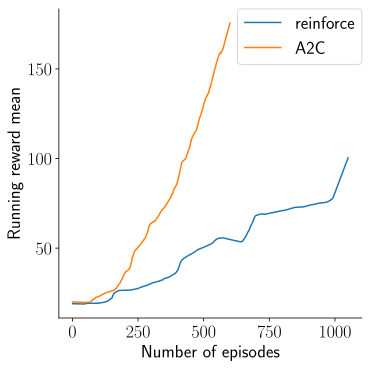

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from solvers.visuals import _clean_figure

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
mean, std = compute_stats(out_reinf['trace']['score'])
ax.plot(out_reinf['trace']['e'],mean,label='reinforce')

mean, std = compute_stats(out_a2c['trace']['score'])
ax.plot(out_a2c['trace']['e'],mean,label='A2C')
sns.despine()
ax.set_xlabel('Number of episodes')
ax.set_ylabel('Running reward mean')
fig.legend(fontsize=18)
plt.tight_layout()
_clean_figure(ax)
plt.savefig('assignment2.pdf',dpi=500,bbox_inches='tight')
plt.show()